# 구현 초기 설정
- Google Colab Pro

In [1]:
# 구글 드라이브에 연결하는 코드
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 구글 드라이브에 경로를 설정하고 git-hub에서 오픈소스 deepface를 다운로드하는 코드
import os 
os.chdir('/content/drive/MyDrive/ArcFace')
# !git clone https://github.com/serengil/deepface.git

# 필수 라이브러리 설치하는 코드
os.chdir('deepface/')
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 KB 9.1 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=c88aef393d37a6a3560b3195d5bec2264c600b90894770ec77955f8eecb426f2
  Stored in directory: /root/.cache/pip/wheels/f7/f1/89/b9ea2bf8f80ec027a88fef1d354b3816b4d3d29530988972f6
Successfully built fire


In [1]:
import os  # 운영체제와 소통하고 경로 관련 모듈 
import sys  # 운영체제와 소통하는 모듈
from pathlib import Path  # 경로 관련 모듈

# sys.path 경로에 현재 dir 추가하는 코드 
ROOT = '/content/drive/MyDrive/ArcFace/deepface'
if ROOT not in sys.path: 
    sys.path.append(str(ROOT)) 

from deepface import DeepFace  # 오픈 소스 모델
from tqdm import tqdm  # 반복문 진행 상황 알려주는 모듈
from random import seed
from random import randint

#### Model Check

In [2]:
# 학습 경로
dataset = '/content/drive/MyDrive/data/new_dataset'
i = 1 # dataset 인덱스
data_path = f'{dataset}/{i}'
data_path = f'{dataset}/{i}'
os.chdir(f'{dataset}/{i}')
file_list=os.listdir()
face_path = f'{data_path}/{file_list[0]}'
card_path = f'{data_path}/{file_list[1]}'

# 모델 리스트
model_list = ['ArcFace', 'VGG-Face', 'DeepFace', 'Facenet']

# 모델 실행
for m in  model_list:
  result = DeepFace.verify(img1_path=face_path, img2_path=card_path,  model_name=m)                                              
  res = result['verified']
  dist = result['distance']

  # 결과
  print(res, dist)

True 0.4250343236237297
True 0.20739333821065287
False 0.2652643757311539
True 0.2832850215333511


# 사전 학습 모델 선택
- 실제 양성 데이터 96개, 실제 음성 데이터 192개로 정확도 측정
- 정확도가 가장 높은 사전학습 모델을 튜닝하여 우리 모델에 활용

In [ ]:
dataset = '/content/drive/MyDrive/data/new_dataset'  # 데이터셋 경로
set_num = len(os.listdir(dataset))  # 데이터 셋 개수

# 정확도 테스트 사용자 정의 함수
def acc_test(model_name):  #model_name : 사용할 모델명
  # TP 구하는 코드
  TP = 0  # 진양성 카운트하는 변수
  for i in tqdm(range(1,set_num+1)):
      data_path = f'{dataset}/{i}'
      os.chdir(f'{dataset}/{i}')
      file_list=os.listdir()
      face_path = f'{data_path}/{file_list[0]}'  # 얼굴 사진 경로
      card_path = f'{data_path}/{file_list[1]}'  # 신분증 사진 경로
      try: 
          result = DeepFace.verify(img1_path=face_path, 
                                  img2_path=card_path, 
                                  model_name=model_name)                                                      
          res, dist = result['verified'], result['distance']
          if res == 1: 
            TP += 1
      except:
          print(f'#{i} 얼굴 검출 실패!')

  # TP 결과
  print(f'진양성: {TP}/{set_num}')

  # TN 구하는 코드
  seed(1)
  TN = 0  # 진음성 카운트 변수
  for k in tqdm(range(1,(set_num*2)+1)):

      while True:
          i = randint(1,set_num)
          j = randint(1,set_num)
          if i != j : 
            break 

      face_path = f'{dataset}/{i}'
      os.chdir(f'{face_path}')
      file_list=os.listdir()
      face_path = f'{face_path}/{file_list[0]}'
      
      card_path = f'{dataset}/{j}'
      os.chdir(f'{card_path}')
      file_list=os.listdir()
      card_path = f'{card_path}/{file_list[1]}'

      try: 
          result = DeepFace.verify(img1_path=face_path, 
                                  img2_path=card_path, 
                                  model_name='ArcFace')                                                      
          res, dist = result['verified'], result['distance']
          if res == 0: 
            TN += 1
      except:
          print(f'#Face{i}, ID{j} 얼굴 검출 실패!')

  # TN 결과 출력
  print(f'진음성: {TN}/{(set_num*2)}')

  # 정확도 결과 출력
  ALL = set_num*3  # TP,NP,FP,FN
  acc =  (TP+TN) / ALL
  print(f'{model_name} Accuracy : {acc}')

### ArcFace 

In [ ]:
acc_test('ArcFace')

100%|██████████| 96/96 [03:53<00:00,  2.44s/it]


Sensitivity: 96/96


100%|██████████| 192/192 [07:53<00:00,  2.47s/it]

Specificity: 154/192
ArcFace Accuracy : 0.8680555555555556


### VGGFace

In [ ]:
acc_test('VGG-Face')

100%|██████████| 96/96 [04:01<00:00,  2.52s/it]


Sensitivity: 90/96


100%|██████████| 192/192 [07:56<00:00,  2.48s/it]

Specificity: 154/192
VGG-Face Accuracy : 0.8472222222222222


### DeepFace

In [ ]:
acc_test('DeepFace')

100%|██████████| 96/96 [04:18<00:00,  2.70s/it]


Sensitivity: 19/96


100%|██████████| 192/192 [07:52<00:00,  2.46s/it]

Specificity: 154/192
DeepFace Accuracy : 0.6006944444444444


### FaceNet

In [ ]:
acc_test('Facenet')

100%|██████████| 96/96 [04:03<00:00,  2.54s/it]


Sensitivity: 74/96


100%|██████████| 192/192 [07:59<00:00,  2.50s/it]

Specificity: 154/192
Facenet Accuracy : 0.7916666666666666


# 임계값 최적화 학습

In [ ]:
# threshold 0.615일때 정확도 0.92 보고

100%|██████████| 96/96 [03:56<00:00,  2.47s/it]


Sensitivity: 93/96


100%|██████████| 192/192 [07:55<00:00,  2.48s/it]

Specificity: 169/192
ArcFace Accuracy : 0.9097222222222222


In [3]:
def find_threshold(model_name, lr, epoch, th=0.68):
  dataset = '/content/drive/MyDrive/data/new_dataset'  # 데이터셋 경로
  set_num = len(os.listdir(dataset))  # 데이터 셋 개수
  acc_list = []
  threshold_list = []
  for e in tqdm(range(epoch)):
    # 진양성 검사
    TP = 0  # 진양성 카운트하는 변수
    for i in range(1,set_num+1):
        data_path = f'{dataset}/{i}'
        os.chdir(f'{dataset}/{i}')
        file_list=os.listdir()
        face_path = f'{data_path}/{file_list[0]}'
        card_path = f'{data_path}/{file_list[1]}'
        try: 
            result = DeepFace.verify(img1_path=face_path, 
                                    img2_path=card_path, 
                                    model_name=model_name)                                                      
            res, dist = result['verified'], result['distance']
            if dist <= th-(lr*e): 
              TP += 1
        except:
            print(f'#{i} 얼굴 검출 실패!')

    # 진음성 검사
    seed(1)
    TN = 0  # 진음성 카운트 변수
    for _ in range(1,(set_num*2)+1):

        while True:
            i = randint(1,set_num)
            j = randint(1,set_num)
            if i != j : 
              break 

        face_path = f'{dataset}/{i}'
        os.chdir(f'{face_path}')
        file_list=os.listdir()
        face_path = f'{face_path}/{file_list[0]}'
        
        card_path = f'{dataset}/{j}'
        os.chdir(f'{card_path}')
        file_list=os.listdir()
        card_path = f'{card_path}/{file_list[1]}'

        try: 
            result = DeepFace.verify(img1_path=face_path, 
                                    img2_path=card_path, 
                                    model_name='ArcFace')                                                      
            res, dist = result['verified'], result['distance']
            if dist > th-(lr*e): 
              TN += 1
        except:
            if i<10:i='0'+str(i)
            if j<10:j='0'+str(j)
            print(f'#Face{i}, ID{j} 얼굴 검출 실패!')
        
    ALL = set_num*3  # TP,NP,FP,FN
    acc =  (TP+TN) / ALL

    print(f'Threshold : {th-(lr*e)}, ACC : {acc}')

    acc_list.append(acc)
    threshold_list.append(th-(lr*e))
  
  acc = max(acc_list)
  threshold = th-(lr*(acc_list.index(acc)+1))
  history = [acc, threshold, acc_list, threshold_list]

  return history

In [4]:
pretrained_model = 'ArcFace'
lr = 0.005
epoch = 24

# 시작 8시 43분 ~ 종료 예정 18시 13분
h = find_threshold(pretrained_model, lr, epoch)

  4%|▍         | 1/24 [23:30<9:00:36, 1410.30s/it]

Threshold : 0.68, ACC : 0.8680555555555556


  8%|▊         | 2/24 [47:52<8:48:21, 1441.00s/it]

Threshold : 0.675, ACC : 0.8715277777777778


 12%|█▎        | 3/24 [1:11:33<8:21:02, 1431.56s/it]

Threshold : 0.67, ACC : 0.8715277777777778


 17%|█▋        | 4/24 [1:35:11<7:55:26, 1426.34s/it]

Threshold : 0.665, ACC : 0.8784722222222222


 21%|██        | 5/24 [1:58:54<7:31:15, 1425.05s/it]

Threshold : 0.66, ACC : 0.8958333333333334


 25%|██▌       | 6/24 [2:22:26<7:06:11, 1420.63s/it]

Threshold : 0.655, ACC : 0.8993055555555556


 29%|██▉       | 7/24 [2:45:53<6:41:17, 1416.30s/it]

Threshold : 0.65, ACC : 0.9027777777777778


 33%|███▎      | 8/24 [3:09:19<6:16:47, 1412.96s/it]

Threshold : 0.645, ACC : 0.90625


 38%|███▊      | 9/24 [3:32:39<5:52:13, 1408.92s/it]

Threshold : 0.64, ACC : 0.90625


 42%|████▏     | 10/24 [3:56:06<5:28:35, 1408.28s/it]

Threshold : 0.635, ACC : 0.90625


 46%|████▌     | 11/24 [4:19:35<5:05:09, 1408.40s/it]

Threshold : 0.63, ACC : 0.8993055555555556


 50%|█████     | 12/24 [4:42:57<4:41:20, 1406.72s/it]

Threshold : 0.625, ACC : 0.90625


 54%|█████▍    | 13/24 [5:06:13<4:17:18, 1403.48s/it]

Threshold : 0.6200000000000001, ACC : 0.9097222222222222


 58%|█████▊    | 14/24 [5:29:31<3:53:37, 1401.79s/it]

Threshold : 0.615, ACC : 0.90625


 62%|██████▎   | 15/24 [5:52:46<3:29:55, 1399.55s/it]

Threshold : 0.6100000000000001, ACC : 0.9097222222222222


 67%|██████▋   | 16/24 [6:16:07<3:06:41, 1400.16s/it]

Threshold : 0.6050000000000001, ACC : 0.9097222222222222


 71%|███████   | 17/24 [6:39:25<2:43:16, 1399.53s/it]

Threshold : 0.6000000000000001, ACC : 0.9097222222222222


 75%|███████▌  | 18/24 [7:02:46<2:19:59, 1399.84s/it]

Threshold : 0.5950000000000001, ACC : 0.9131944444444444


 79%|███████▉  | 19/24 [7:26:04<1:56:36, 1399.36s/it]

Threshold : 0.5900000000000001, ACC : 0.9097222222222222


 83%|████████▎ | 20/24 [7:49:22<1:33:15, 1398.99s/it]

Threshold : 0.5850000000000001, ACC : 0.9097222222222222


 88%|████████▊ | 21/24 [8:12:26<1:09:43, 1394.36s/it]

Threshold : 0.5800000000000001, ACC : 0.9097222222222222


 92%|█████████▏| 22/24 [8:35:43<46:30, 1395.15s/it]  

Threshold : 0.5750000000000001, ACC : 0.9027777777777778


 96%|█████████▌| 23/24 [8:58:46<23:11, 1391.56s/it]

Threshold : 0.5700000000000001, ACC : 0.8993055555555556


100%|██████████| 24/24 [9:22:05<00:00, 1405.24s/it]

Threshold : 0.5650000000000001, ACC : 0.8993055555555556


In [5]:
# 시작 시간 8시 43분 ~  종료 예정 시간 18시 13분 (9시간 30분 소요 예정)
print(f'best acc : {h[0]}, best_threshold : {h[1]}')

best acc : 0.9131944444444444, best_threshold : 0.5900000000000001


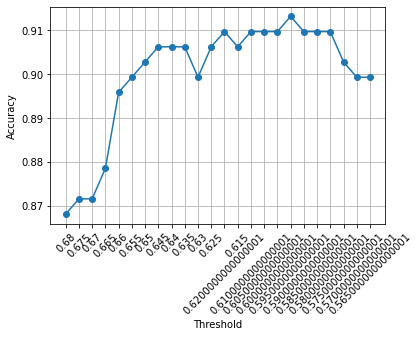

In [7]:
import matplotlib.pyplot as plt

acc_list = h[2]
th_list = h[3]
x_ticks = []
s = 1
for _ in range(epoch):
    x_ticks.append(s)
    s += 1

plt.plot(x_ticks, acc_list,marker='o')
plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.xticks(x_ticks, th_list, rotation=45)
plt.grid()
plt.show()
